In [43]:
import tkinter as tk
import matplotlib.pyplot as plt
import numpy as np
import svgpathtools
import matplotlib.animation as animation
from tkinter import messagebox, colorchooser
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

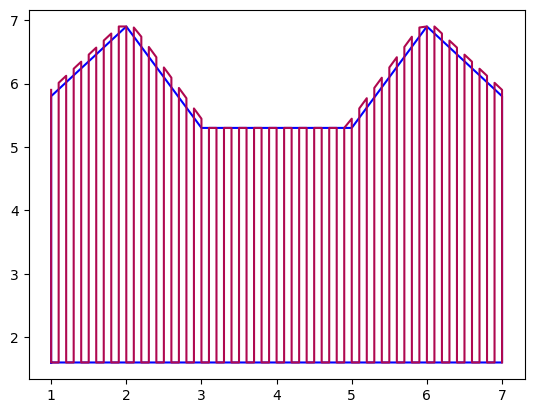

In [44]:
def load_svg():
    file_path = "./models/casa.svg"
    paths, _ = svgpathtools.svg2paths(file_path)
    process_svg(paths)

def process_svg(paths):
    trajectory = []
    for path in paths:
        for segment in path:
            points = np.linspace(0, 1, 100)
            for point in points:
                pos = segment.point(point)
                trajectory.append((pos.real, pos.imag))
    
    generate_printing_path(trajectory)

def validate_resolution():
    """Valida que la distancia entre puntos esté en el rango permitido."""
    try:
        value = float(resolution_entry.get())
        if 0.01 <= value <= 0.1:
            return value
        else:
            messagebox.showerror("Error", "La distancia entre puntos debe estar entre 0.01 y 0.1 mm.")
            resolution_entry.delete(0, tk.END)
            resolution_entry.insert(0, "0.1")  # Valor predeterminado
            return None
    except ValueError:
        messagebox.showerror("Error", "Ingrese un número válido para la distancia entre puntos.")
        resolution_entry.delete(0, tk.END)
        resolution_entry.insert(0, "0.1")
        return None

def generate_printing_path(trajectory):
    x, y = zip(*trajectory)
    x_min, x_max = min(x), max(x)
    y_min, y_max = min(y), max(y)

    point_spacing = validate_resolution()
    if point_spacing is None:
        return  # No continuar si la validación falla

    printing_path = []
    
    x_current = x_min
    direction_y = -1
    while x_current <= x_max:
        y_positions = sorted({y_pos for x_pos, y_pos in trajectory if abs(x_pos - x_current) < point_spacing})
        if y_positions:
            if direction_y == -1:
                y_positions.reverse()
            for y_current in y_positions:
                if y_min <= y_current <= y_max:
                    printing_path.append((x_current, max(y_min, min(y_current, y_max))))
            direction_y *= -1
        x_current += point_spacing
    
    animate_trajectory(trajectory, printing_path)

def choose_color():
    """Permite al usuario seleccionar un color para la trayectoria."""
    color = colorchooser.askcolor(title="Selecciona un color")[1]
    if color:
        color_var.set(color)

def animate_trajectory(trajectory, printing_path):
    global canvas, ani, ax

    ax.clear()
    x, y = zip(*trajectory)
    x_print, y_print = zip(*printing_path)

    color = color_var.get()
    style = style_var.get()

    # Mapeo de estilos para matplotlib
    line_styles = {
        "Línea continua": "-",
        "Puntos": ":",
        "Línea entrecortada": "--",
        "Puntos y líneas": "-."
    }

    ax.plot(x, y, label='Contorno SVG', color='blue')
    line, = ax.plot([], [], label='Trayectoria de Impresión', color=color, linestyle=line_styles[style])

    def update(frame):
        if frame < len(x_print):
            line.set_data(x_print[:frame+1], y_print[:frame+1])
            return line,
        else:
            ani.event_source.stop()  # Detener animación al final
            return line,

    speed = float(speed_entry.get()) if speed_entry.get() else 50
    ani = animation.FuncAnimation(fig, update, frames=len(x_print), interval=speed, blit=True, repeat=False)
    canvas.draw()

def start_ui():
    global resolution_entry, speed_entry, color_var, style_var, canvas, fig, ax, root

    root = tk.Tk()
    root.title("3D Printer Configuration")

    control_frame = tk.Frame(root)
    control_frame.pack(side=tk.LEFT, padx=10, pady=10)

    tk.Label(control_frame, text="Distancia entre puntos (0.01 - 0.1 mm)").pack()
    resolution_entry = tk.Entry(control_frame)
    resolution_entry.pack()
    resolution_entry.insert(0, "0.1")

    tk.Label(control_frame, text="Velocidad de Animación (ms)").pack()
    speed_entry = tk.Entry(control_frame)
    speed_entry.pack()
    speed_entry.insert(0, "10")

    tk.Label(control_frame, text="Color de la línea").pack()
    color_var = tk.StringVar(value="black")  # Valor inicial negro
    color_button = tk.Button(control_frame, text="Seleccionar Color", command=choose_color)
    color_button.pack()

    tk.Label(control_frame, text="Estilo de trayectoria").pack()
    style_var = tk.StringVar(value="Línea continua")
    style_options = ["Línea continua", "Puntos", "Línea entrecortada", "Puntos y líneas"]
    style_menu = tk.OptionMenu(control_frame, style_var, *style_options)
    style_menu.pack()

    load_button = tk.Button(control_frame, text="Cargar Archivo SVG", command=load_svg)
    load_button.pack()

    fig, ax = plt.subplots()
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)
    
    root.mainloop()

if __name__ == "__main__":
    start_ui()


In [3]:
import tkinter as tk
from tkinter import filedialog
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import numpy as np
import svgpathtools


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\luis3\AppData\Local\Programs\Python\Python313\Lib\tkinter\__init__.py", line 2068, in __call__
    return self.func(*args)
           ~~~~~~~~~^^^^^^^
  File "C:\Users\luis3\AppData\Local\Temp\ipykernel_16364\789249606.py", line 11, in load_svg
    process_svg(paths)
    ~~~~~~~~~~~^^^^^^^
  File "C:\Users\luis3\AppData\Local\Temp\ipykernel_16364\789249606.py", line 21, in process_svg
    plot_trajectory(trajectory)
    ~~~~~~~~~~~~~~~^^^^^^^^^^^^
  File "C:\Users\luis3\AppData\Local\Temp\ipykernel_16364\789249606.py", line 35, in plot_trajectory
    y_max = -0.094*x**4 + 1.51*x**3 - 8.04*x**2 + 16.07 * x - 3.65
                   ~^^~
TypeError: unsupported operand type(s) for ** or pow(): 'tuple' and 'int'


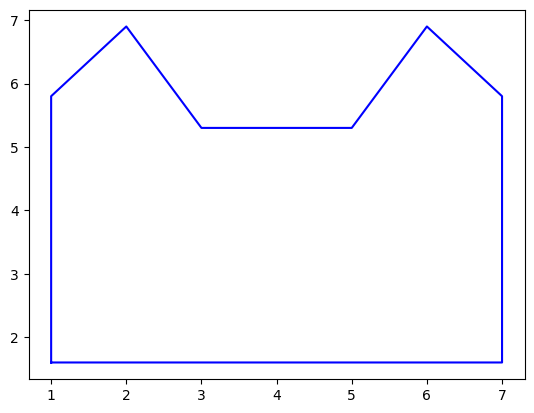

In [16]:


def load_svg():
    file_path = "./models/casa.svg"
    paths, _ = svgpathtools.svg2paths(file_path)
    process_svg(paths)

def process_svg(paths):
    trajectory = []
    for path in paths:
        for segment in path:
            points = np.linspace(0, 1, 100)
            for point in points:
                pos = segment.point(point)
                trajectory.append((pos.real, pos.imag))
    plot_trajectory(trajectory)

def plot_trajectory(trajectory):
    x, y = zip(*trajectory)
    fig, ax = plt.subplots()
    
    # Dibujar la trayectoria del SVG
    ax.plot(x, y, label='3D Printing Path', color='blue')

    # Obtener dominio y recorrido de la función desde la entrada del usuario
    try:
        x_min = float(domain_min_entry.get())
        x_max = float(domain_max_entry.get())
        y_min = float(range_min_entry.get())
        y_max = -0.094*x**4 + 1.51*x**3 - 8.04*x**2 + 16.07 * x - 3.65
        
        x_func = np.linspace(x_min, x_max, 200)
        y_func = np.sin(x_func) * ((y_max - y_min) / 2) + ((y_max + y_min) / 2)  # Función de ejemplo

        # Dibujar la función matemática en la misma figura
        ax.plot(x_func, y_func, label='Función Matemática', color='red', linestyle='--')
    except ValueError:
        print("Por favor, ingrese valores numéricos válidos para el dominio y el recorrido.")

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Printing Path Visualization with Function')
    ax.legend()
    
    # Mostrar la gráfica en Tkinter
    for widget in plot_frame.winfo_children():
        widget.destroy()
    
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas.draw()
    canvas.get_tk_widget().pack()

def start_ui():
    global domain_min_entry, domain_max_entry, range_min_entry, range_max_entry, plot_frame
    root = tk.Tk()
    root.title("3D Printer Configuration")
    
    tk.Label(root, text="Resolución de Impresión (mm)").pack()
    resolution_entry = tk.Entry(root)
    resolution_entry.pack()

    tk.Label(root, text="Velocidad de Impresión (mm/s)").pack()
    speed_entry = tk.Entry(root)
    speed_entry.pack()

    tk.Label(root, text="Dominio mínimo").pack()
    domain_min_entry = tk.Entry(root)
    domain_min_entry.pack()

    tk.Label(root, text="Dominio máximo").pack()
    domain_max_entry = tk.Entry(root)
    domain_max_entry.pack()

    tk.Label(root, text="Recorrido mínimo").pack()
    range_min_entry = tk.Entry(root)
    range_min_entry.pack()

    #tk.Label(root, text="Recorrido máximo").pack()
    #range_max_entry = tk.Entry(root)
    #range_max_entry.pack()

    load_button = tk.Button(root, text="Cargar Archivo SVG", command=load_svg)
    load_button.pack()

    # Frame para la gráfica
    plot_frame = tk.Frame(root)
    plot_frame.pack()
    
    root.mainloop()

if __name__ == "__main__":
    start_ui()


In [17]:
import tkinter as tk
from tkinter import filedialog
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import numpy as np
import svgpathtools

def load_svg():
    file_path = "./models/casa.svg"
    paths, _ = svgpathtools.svg2paths(file_path)
    process_svg(paths)

def process_svg(paths):
    trajectory = []
    for path in paths:
        for segment in path:
            points = np.linspace(0, 1, 100)
            for point in points:
                pos = segment.point(point)
                trajectory.append((pos.real, pos.imag))
    plot_trajectory(trajectory)

def plot_trajectory(trajectory):
    x, y = zip(*trajectory)
    fig, ax = plt.subplots()
    
    # Dibujar la trayectoria del SVG
    ax.plot(x, y, label='3D Printing Path', color='blue')

    # Obtener dominio y recorrido de la función desde la entrada del usuario
    try:
        x_min = float(domain_min_entry.get())
        x_max = float(domain_max_entry.get())
        y_min = float(range_min_entry.get())

        # Evaluar la función definida por el usuario para determinar ymax
        function_str = function_entry.get()
        x_vals = np.linspace(x_min, x_max, 200)
        y_max_vals = eval(function_str, {"np": np, "x": x_vals})
        y_max = max(y_max_vals)  # Obtener el máximo de la función en el dominio
        
        y_func = np.sin(x_vals) * ((y_max - y_min) / 2) + ((y_max + y_min) / 2)  # Función de ejemplo

        # Dibujar la función matemática en la misma figura
        ax.plot(x_vals, y_func, label='Función Matemática', color='red', linestyle='--')
    except Exception as e:
        print("Error al evaluar la función:", e)

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Printing Path Visualization with Function')
    ax.legend()
    
    # Mostrar la gráfica en Tkinter
    for widget in plot_frame.winfo_children():
        widget.destroy()
    
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas.draw()
    canvas.get_tk_widget().pack()

def start_ui():
    global domain_min_entry, domain_max_entry, range_min_entry, function_entry, plot_frame
    root = tk.Tk()
    root.title("3D Printer Configuration")
    
    tk.Label(root, text="Resolución de Impresión (mm)").pack()
    resolution_entry = tk.Entry(root)
    resolution_entry.pack()

    tk.Label(root, text="Velocidad de Impresión (mm/s)").pack()
    speed_entry = tk.Entry(root)
    speed_entry.pack()

    tk.Label(root, text="Dominio mínimo").pack()
    domain_min_entry = tk.Entry(root)
    domain_min_entry.pack()

    tk.Label(root, text="Dominio máximo").pack()
    domain_max_entry = tk.Entry(root)
    domain_max_entry.pack()

    tk.Label(root, text="Recorrido mínimo").pack()
    range_min_entry = tk.Entry(root)
    range_min_entry.pack()

    tk.Label(root, text="Función para ymax (ej: np.sin(x) * 5 + 10)").pack()
    function_entry = tk.Entry(root)
    function_entry.pack()

    load_button = tk.Button(root, text="Cargar Archivo SVG", command=load_svg)
    load_button.pack()

    # Frame para la gráfica
    plot_frame = tk.Frame(root)
    plot_frame.pack()
    
    root.mainloop()

if __name__ == "__main__":
    start_ui()


Iteración:  1
Coeficientes del polinomio: [1.44571523e-16 6.00000000e+00]
Error cuadrático medio: 5.174999999999997


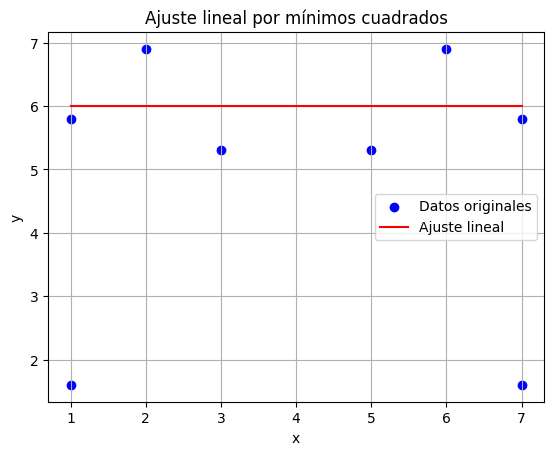

Iteración:  2
Coeficientes del polinomio: [ 0.03367347 -0.26938776  6.38163265]
Error cuadrático medio: 5.492083246563929


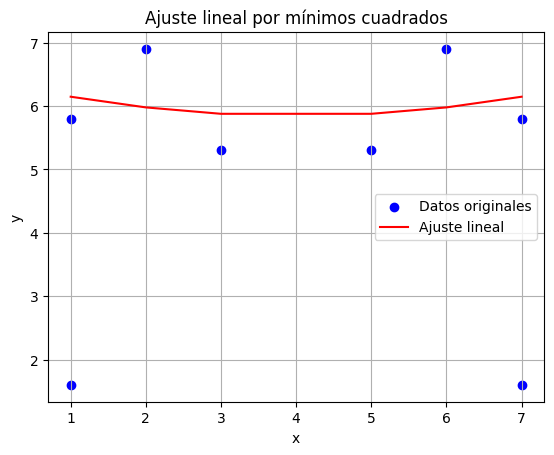

Iteración:  3
Coeficientes del polinomio: [-2.68535307e-16  3.36734694e-02 -2.69387755e-01  6.38163265e+00]
Error cuadrático medio: 5.492083246563933


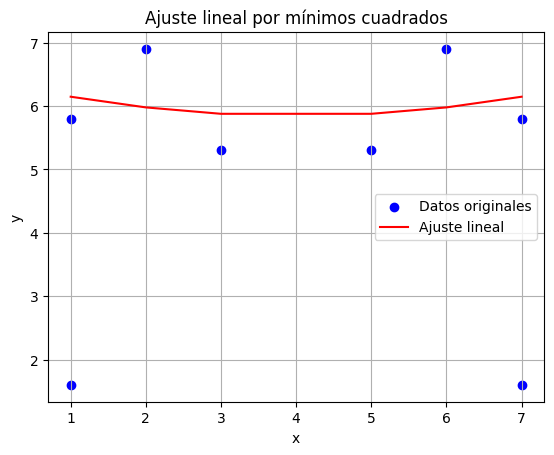

Iteración:  4
Coeficientes del polinomio: [-0.09416667  1.50666667 -8.03583333 16.07333333 -3.65      ]
Error cuadrático medio: 4.409999999999784


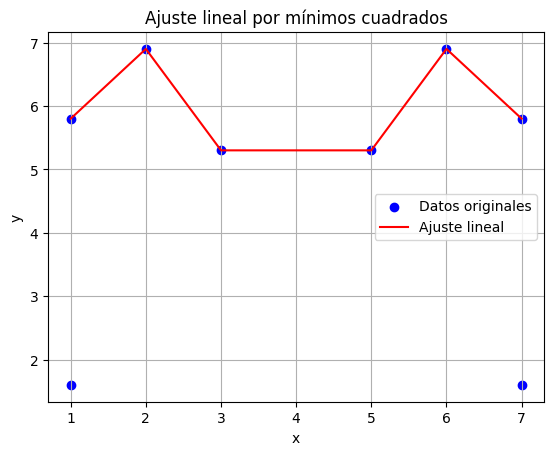

Iteración:  5
Coeficientes del polinomio: [-2.24485842e-15 -9.41666667e-02  1.50666667e+00 -8.03583333e+00
  1.60733333e+01 -3.65000000e+00]
Error cuadrático medio: 4.409999999999833


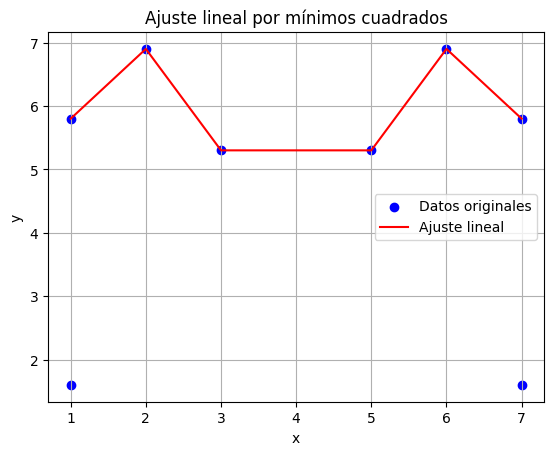

Iteración:  6
Coeficientes del polinomio: [ 6.46978353e-04 -1.55274805e-02  5.20504410e-02  8.23457526e-01
 -6.38927343e+00  1.41634532e+01 -2.83480728e+00]
Error cuadrático medio: 4.410000000000229


C:\Users\luis3\AppData\Local\Temp\ipykernel_16364\1865759083.py:18: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(xs_reducidos, ys_reducidos, i)


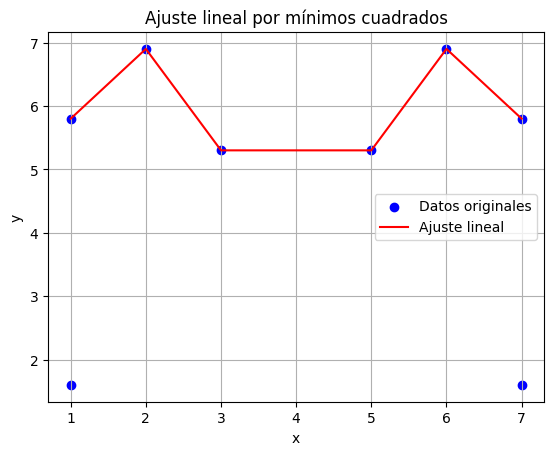

Parámetros óptimos: a = -0.0000, b = 4.9001
Error cuadrático medio (MSE): 3.9650


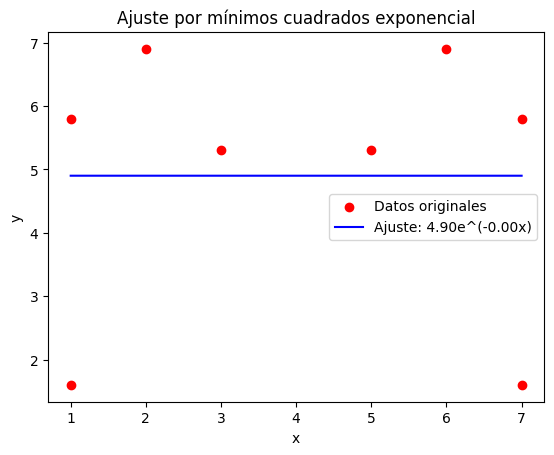

Parámetros óptimos: a = 0.0533, b = 4.6087
Error cuadrático medio (MSE): 3.9202


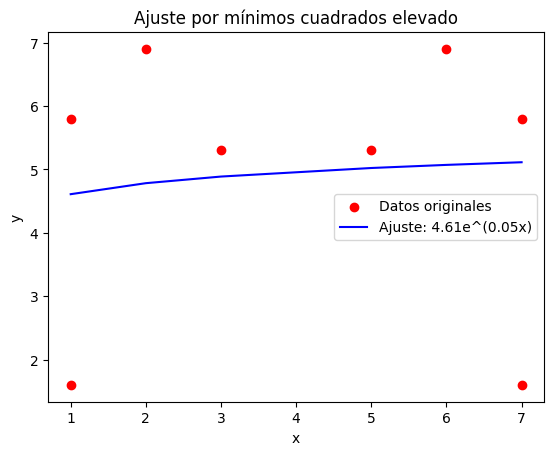

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Definir los puntos
xs = np.array([ 1, 1, 2, 3, 5, 6, 7, 7 ])
ys = np.array([ 1.6, 5.8, 6.9, 5.3, 5.3, 6.9, 5.8, 1.6 ])

xs_reducidos = xs[1:-1]  
ys_reducidos = ys[1:-1]  

# Ajustar un polinomio de grado 1 (lineal) usando el método de mínimos cuadrados
i = 1
for i in range(1, 7):
    print("Iteración: ", i)
    
    # Ajustar un polinomio de grado 1 (lineal) usando el método de mínimos cuadrados
    coefficients = np.polyfit(xs_reducidos, ys_reducidos, i)
    polynomial = np.poly1d(coefficients)

    # Calcular los valores ajustados
    ys_fit = polynomial(xs)

    # Calcular el error cuadrático medio
    error = np.mean((ys - ys_fit) ** 2)

    print("Coeficientes del polinomio:", coefficients)
    print("Error cuadrático medio:", error)

    plt.scatter(xs, ys, color='blue', label='Datos originales')
    plt.plot(xs, ys_fit, color='red', label='Ajuste lineal')
    plt.xlabel('x')
    plt.ylabel('y')
    #plt.xlim(3, 8)
    #plt.ylim(100, 350)
    plt.title('Ajuste lineal por mínimos cuadrados')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    i += 1


# Datos de ejemplo
# Modelo de la for ma b * e^(a * x)
def modelo_exponencial(xs, a, b):
    return b * np.exp(a * xs)

# Ajuste del modelo
parametros_optimos, _ = curve_fit(modelo_exponencial, xs, ys)
a_opt, b_opt = parametros_optimos

# Predicciones del modelo
y_pred = modelo_exponencial(xs, a_opt, b_opt)

# Cálculo del error cuadrático medio (MSE)
mse = np.mean((ys - y_pred)**2)

# Resultados
print(f"Parámetros óptimos: a = {a_opt:.4f}, b = {b_opt:.4f}")
print(f"Error cuadrático medio (MSE): {mse:.4f}")

# Visualización
plt.scatter(xs, ys, label="Datos originales", color="red")
plt.plot(xs, y_pred, label=f"Ajuste: {b_opt:.2f}e^({a_opt:.2f}x)", color="blue")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Ajuste por mínimos cuadrados exponencial")
plt.show()


def modelo_exponente(xs, a, b):
    return b * xs**(a)

# Ajuste del modelo
parametros_optimos, _ = curve_fit(modelo_exponente, xs, ys)
a_opt, b_opt = parametros_optimos

# Predicciones del modelo
y_pred = modelo_exponente(xs, a_opt, b_opt)

# Cálculo del error cuadrático medio (MSE)
mse = np.mean((ys - y_pred)**2)

# Resultados
print(f"Parámetros óptimos: a = {a_opt:.4f}, b = {b_opt:.4f}")
print(f"Error cuadrático medio (MSE): {mse:.4f}")

# Visualización
plt.scatter(xs, ys, label="Datos originales", color="red")
plt.plot(xs, y_pred, label=f"Ajuste: {b_opt:.2f}e^({a_opt:.2f}x)", color="blue")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Ajuste por mínimos cuadrados elevado")
plt.show()
